In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import skew 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingRegressor as xgb 
from sklearn.preprocessing import Imputer

In [2]:
os.chdir('E:\Sem4\Kaggle Project\house-prices-advanced-regression-techniques')

In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')


Text(0.5,1,'Sale Price vs OverallQual')

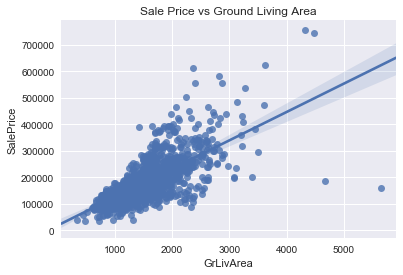

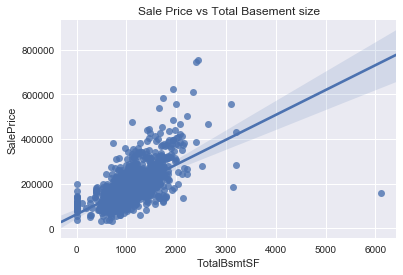

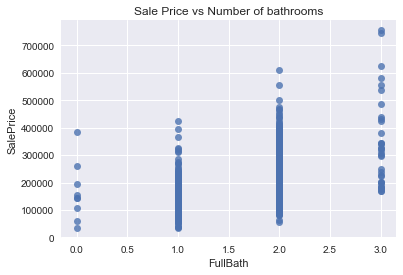

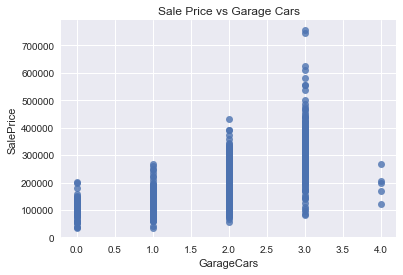

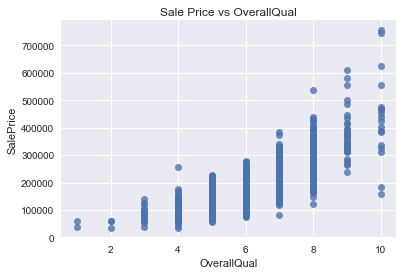

In [5]:
plt.figure(1)
sns.set(color_codes=True)
ax = sns.regplot(x="GrLivArea", y="SalePrice", data=train_data)
plt.title('Sale Price vs Ground Living Area')

plt.figure(2)
sns.set(color_codes=True)
ax = sns.regplot(x="TotalBsmtSF", y="SalePrice", data=train_data)
plt.title('Sale Price vs Total Basement size')

plt.figure(3)
sns.set(color_codes=True)
ax = sns.regplot(x="FullBath", y="SalePrice", data=train_data, fit_reg = False)
plt.title('Sale Price vs Number of bathrooms')


plt.figure(4)
sns.set(color_codes=True)
ax = sns.regplot(x="GarageCars", y="SalePrice", data=train_data, fit_reg = False)
plt.title('Sale Price vs Garage Cars')

plt.figure(5)
sns.set(color_codes=True)
ax = sns.regplot(x="OverallQual", y="SalePrice", data=train_data, fit_reg = False)
plt.title('Sale Price vs OverallQual')




In [6]:
train_data.sort_values(by = 'SalePrice', ascending = False)[:10]['SalePrice']

691     755000
1182    745000
1169    625000
898     611657
803     582933
1046    556581
440     555000
769     538000
178     501837
798     485000
Name: SalePrice, dtype: int64

In [7]:
train_data.sort_values(by = 'GrLivArea', ascending = False)[:10]['GrLivArea']

1298    5642
523     4676
1182    4476
691     4316
1169    3627
185     3608
304     3493
1268    3447
635     3395
769     3279
Name: GrLivArea, dtype: int64

In [8]:
train_data.sort_values(by = 'TotalBsmtSF', ascending = False)[:10]['TotalBsmtSF']

1298    6110
332     3206
496     3200
523     3138
440     3094
1373    2633
1044    2524
691     2444
1182    2396
224     2392
Name: TotalBsmtSF, dtype: int64

In [9]:
outliers = [30, 88, 462, 631, 1322]
train_data = train_data.drop(train_data.index[outliers])
# y = y.drop(y.index[outliers])



In [10]:
train_data.drop(train_data[(train_data['OverallQual']<5) & (train_data['SalePrice']>200000)].index, inplace=True)
train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index, inplace=True)
train_data.reset_index(drop=True, inplace=True)

In [11]:
comb_data = pd.concat((train_data.loc[:,'MSSubClass':'SaleCondition'],
                      test_data.loc[:,'MSSubClass':'SaleCondition']))

In [12]:
num_var = [f for f in train_data.columns if train_data.dtypes[f] != 'object']
num_var.remove('SalePrice')
num_var.remove('Id')
cat_var = [f for f in train_data.columns if train_data.dtypes[f] == 'object']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A6BFE65048>,
      dtype=object)

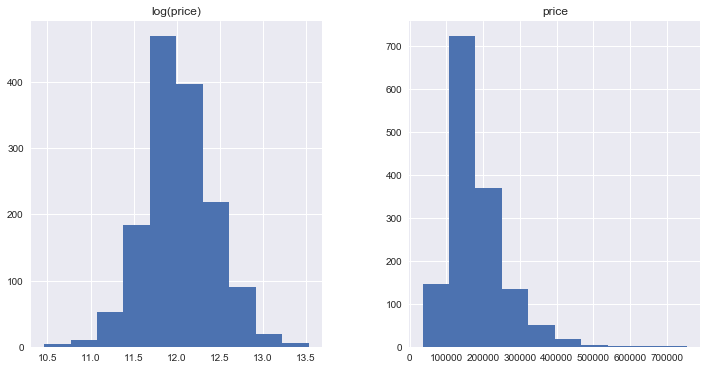

In [13]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train_data["SalePrice"], "log(price)":np.log1p(train_data["SalePrice"])})
prices.hist()

In [14]:
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

In [15]:
missing_variables = pd.DataFrame(comb_data.isnull().sum())
missing_variables = missing_variables[missing_variables[0]>0]
missing_variables

,0
MSZoning,4
LotFrontage,485
Alley,2714
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,24
MasVnrArea,23
BsmtQual,81
BsmtCond,82


In [16]:
for col in ('BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtCond', 
           'BsmtQual','MasVnrType', 'GarageCond','GarageFinish','GarageQual',
           'GarageType','MiscFeature','FireplaceQu','Fence','PoolQC','Alley'):
      comb_data[col]= comb_data[col].fillna('None')

    

In [17]:
for col in ('Utilities','Functional','Exterior1st','Exterior2nd','MSZoning','KitchenQual','SaleType','Electrical'):
    comb_data[col]= comb_data[col].fillna(train_data[col].mode()[0])

In [18]:
miss_num_var = [f for f in missing_variables.index.tolist() if f in num_var]
miss_cat_var = [f for f in missing_variables.index.tolist() if f in cat_var]
miss_num_var

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [19]:
for col in miss_num_var:
    comb_data[col]= comb_data[col].fillna(0)

In [20]:
skew_features = train_data[num_var].apply(lambda x: skew(x)).sort_values(ascending=False)

In [21]:
skew_features

MiscVal          24.384665
PoolArea         15.899328
LotArea          12.738001
3SsnPorch        10.264751
LowQualFinSF      9.234692
KitchenAbvGr      4.469701
BsmtFinSF2        4.249826
ScreenPorch       4.104812
BsmtHalfBath      4.086006
EnclosedPorch     3.120534
OpenPorchSF       2.339541
WoodDeckSF        1.547835
MSSubClass        1.406822
GrLivArea         1.010686
BsmtUnfSF         0.922159
1stFlrSF          0.888911
2ndFlrSF          0.811567
BsmtFinSF1        0.765003
OverallCond       0.711663
HalfBath          0.675959
TotRmsAbvGrd      0.657378
Fireplaces        0.633102
BsmtFullBath      0.589123
TotalBsmtSF       0.510938
MoSold            0.215728
BedroomAbvGr      0.209324
OverallQual       0.205514
GarageArea        0.135564
YrSold            0.098094
FullBath          0.028437
GarageCars       -0.340785
YearRemodAdd     -0.501869
YearBuilt        -0.614268
LotFrontage            NaN
MasVnrArea             NaN
GarageYrBlt            NaN
dtype: float64

In [22]:
high_skew = skew_features[skew_features > 0.75]
skew_index = high_skew.index

for i in skew_index:
    comb_data[i] = boxcox1p(comb_data[i], boxcox_normmax(comb_data[i] + 1))

C:\Users\manid\Anaconda3\lib\site-packages\scipy\stats\stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\manid\Anaconda3\lib\site-packages\scipy\stats\stats.py:5240: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [23]:
comb_data['Total_sqr_footage']=(comb_data['BsmtFinSF1'] + comb_data['BsmtFinSF2'] +
                                 comb_data['1stFlrSF'] + comb_data['2ndFlrSF'])
comb_data['Total_Bathrooms']=(comb_data['FullBath'] + (0.5 * comb_data['HalfBath']) +
                               comb_data['BsmtFullBath'] + (0.5 * comb_data['BsmtHalfBath']))
comb_data['TotalSF']=(comb_data['TotalBsmtSF'] +  comb_data['1stFlrSF'] + comb_data['2ndFlrSF'])
comb_data['Total_porch_sf'] = (comb_data['OpenPorchSF'] + comb_data['3SsnPorch'] +
                              comb_data['EnclosedPorch'] + comb_data['ScreenPorch'] +
                              comb_data['WoodDeckSF'])

In [24]:
comb_data['haspool'] = comb_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
comb_data['has2ndfloor'] = comb_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
comb_data['hasgarage'] = comb_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
comb_data['hasbsmt'] = comb_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
comb_data['hasfireplace'] = comb_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [25]:
comb_data['Garage_Age']=2019-comb_data['GarageYrBlt']
comb_data['Built_Age']=2019-comb_data['YearBuilt']
comb_data['RemodAdd_Age']=2019-comb_data['YearRemodAdd']
comb_data['Soldyr_age']=2019-comb_data['YrSold']

In [26]:
comb_data['PostCrash']=(comb_data.YrSold>2008)

In [27]:
comb_data=comb_data.drop(columns=['GarageYrBlt','YearBuilt','YearRemodAdd','YrSold'])


In [28]:
comb_data['PostCrash']=comb_data['PostCrash'].astype('int')

In [29]:
comb_data.shape

(2911, 89)

In [30]:
comb_data_final = pd.get_dummies(comb_data).reset_index(drop=True)
comb_data_final.shape

(2911, 311)

In [31]:
overfit = []
for i in comb_data_final.columns:
    counts = comb_data_final[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(comb_data_final) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
comb_data_final = comb_data_final.drop(overfit, axis=1)
# X_sub = X_sub.drop(overfit, axis=1)
overfit

['Utilities_AllPub',
 'Utilities_NoSeWa',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Exterior1st_ImStucc',
 'Exterior2nd_Other',
 'Heating_Floor',
 'Electrical_Mix',
 'MiscFeature_TenC']

In [32]:
data_train = comb_data_final[:train_data.shape[0]]
data_test = comb_data_final[train_data.shape[0]:]
y = train_data.SalePrice

In [36]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [37]:
alphas1 = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [38]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas1, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [39]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)           

In [40]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [41]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [42]:
score = cv_rmse(ridge , data_train,y)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Ridge: 0.1046 (0.0105)
 2019-04-24 22:21:47.726072


In [43]:

score = cv_rmse(lasso , data_train,y)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.1029 (0.0104)
 2019-04-24 22:21:53.393450


In [44]:


score = cv_rmse(elasticnet, data_train,y)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

elastic net: 0.1029 (0.0103)
 2019-04-24 22:22:20.389376


In [45]:
score = cv_rmse(svr, data_train,y)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

SVR: 0.1057 (0.0122)
 2019-04-24 22:22:28.893333


In [46]:
score = cv_rmse(lightgbm, data_train,y)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


lightgbm: 0.1093 (0.0118)
 2019-04-24 22:22:43.772336


In [47]:
score = cv_rmse(gbr, data_train,y)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

gbr: 0.1087 (0.0116)
 2019-04-24 22:24:02.376368


In [48]:
score = cv_rmse(xgboost, data_train,y)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

xgboost: 0.1083 (0.0115)
 2019-04-24 22:27:51.291683


In [49]:


# score = cv_rmse(RFregressor, data_train,y)
# print("RFregressor: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

In [50]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm,svr),
                                meta_regressor=elasticnet,
                                use_features_in_secondary=True)

In [51]:
stack_gen_model = stack_gen.fit(np.array(data_train), np.array(y))

In [52]:

# #Very Slow
# score = cv_rmse(stack_gen, np.array(data_train), np.array(y))
# print("RFregressor: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

In [53]:
elastic_model_full_data = elasticnet.fit(data_train, y)

In [54]:
lasso_model_full_data = lasso.fit(data_train, y)

In [55]:
ridge_model_full_data = ridge.fit(data_train, y)

In [56]:
svr_model_full_data = svr.fit(data_train, y)

In [57]:
gbr_model_full_data = gbr.fit(data_train, y)

In [58]:
xgb_model_full_data = xgboost.fit(data_train, y)

In [59]:
lgb_model_full_data = lightgbm.fit(data_train, y)

In [60]:
# def blend_models_predict(X):
#     return ((0.1 * elastic_model_full_data.predict(X)) + \
#             (0.05 * lasso_model_full_data.predict(X)) + \
#             (0.1 * ridge_model_full_data.predict(X)) + \
#             (0.1 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
#             (0.15 * xgb_model_full_data.predict(X)) + \
#             (0.1 * lgb_model_full_data.predict(X)) + \
#             (0.3 * stack_gen_model.predict(np.array(X))))
def blend_models_predict(X):
    return (((elastic_model_full_data.predict(X)) + \
            (lasso_model_full_data.predict(X)) + \
            (ridge_model_full_data.predict(X)) + \
            (svr_model_full_data.predict(X)) + \
            (gbr_model_full_data.predict(X)) + \
            (xgb_model_full_data.predict(X)) + \
            (lgb_model_full_data.predict(X)) + \
            (stack_gen_model.predict(np.array(X))))/8)

In [61]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(data_train)))

RMSLE score on train data:
0.07620599134506258


In [62]:
test_id = test_data[['Id']]
test_id=test_id.Id.astype(int)

predict = pd.DataFrame(np.exp(blend_models_predict(data_test)), columns= ['SalePrice'])
submission = pd.concat([test_id, predict],axis =1)
submission.to_csv("submission1.csv",header = True, index =False)

In [63]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data_train.columns, gbr.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances[importances['Gini-importance']>0.005]

,Gini-importance
MSSubClass,0.006018
LotFrontage,0.025767
LotArea,0.044090
OverallQual,0.027450
OverallCond,0.043490
MasVnrArea,0.011722
BsmtFinSF1,0.019434
BsmtUnfSF,0.026440
TotalBsmtSF,0.029181
1stFlrSF,0.038001
